In [1]:
import os
import re
import pickle
import pandas as pd
import numpy as np
import scipy.stats as st

from itertools import product
from collections import namedtuple, defaultdict
from collections.abc import Iterable
from functools import reduce
from pathlib import Path

import matplotlib.pyplot as plt

def filter_experiments(experiments, mask):
    # Mask is a namedtuple that has None for fields that are to be ignored
    mask_base = set(filter(lambda y: not isinstance(y[1], tuple), 
                           filter(lambda x: x[1], mask._asdict().items())))
    mask_permutes = set(filter(lambda y: isinstance(y[1], tuple),
                              filter(lambda x: x[1], mask._asdict().items())))
    
    # Delta is the permuting parameter expansions
    delta = list(map(lambda x: set(product((x[0],), x[1])), mask_permutes))
    permutations = [x.union(mask_base) for x in list(map(lambda x: set(x), product(*delta)))]
    
    # All of the experiments that match the filter(s)
    exps = list(map(lambda x: set(filter(lambda y: x <= set(y._asdict().items()), experiments)), permutations))
    
    # Collapse all of the experiments into a set and return it
    return reduce(lambda x, y: x.union(y), exps)

def filter_anomalies(data):
    mean = np.mean(data)
    std = np.std(data)
    
    return [x for x in data if (mean - 2 * std) < x < (mean + 2 * std)]

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [5]:
def graph_data(x_key, y_key, results, control, exp_type, filter_params={}, 
               control_params=None, **kwargs):
    filter_params[x_key] = None  # Set the X value to none for X-axis
    
    if not control_params:
        control_params = dict([(key, None) for key in exp_type._fields])
    filtered_control = filter_experiments(control.keys(), exp_type(**control_params))
    processed_control = []
    for exp in filtered_control:
        exp_data = control[exp]
        exp_data = list(map(lambda x: float(x), 
                            filter(lambda x: x, map(lambda x: x.get(y_key), exp_data))))
        exp_mean, exp_ci = mean_confidence_interval(exp_data)
        
        processed_control.append((exp_mean, exp_ci))
    
    filtered_results = filter_experiments(results.keys(), exp_type(**filter_params))
    processed_results = []
    for exp in filtered_results:
        exp_data = results[exp]
        exp_data = list(map(lambda x: float(x), 
                            filter(lambda x: x, map(lambda x: x.get(y_key), exp_data))))
        exp_mean, exp_ci = mean_confidence_interval(exp_data)
        
        processed_results.append((getattr(exp, x_key), (exp_mean, exp_ci)))
    
    # Sort the x axis in ascending order
    processed_results = sorted(processed_results, key=lambda x: x[0])
    control_value = processed_control[0][0]
    
    # Graph the data
    figsize = kwargs.get('figsize', (15, 10))
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    
    x_axis, data = tuple(list(map(list, zip(*processed_results))))
    axes.set_xticks(x_axis)
    axes.grid(linestyle='--')
    axes.errorbar(x_axis, *list(map(list, zip(*data))),
                 marker='^', color='royalblue', ecolor='orange', capsize=4)
    axes.axhline(control_value, color='orangered', linestyle='--')
    # Config via. KWargs
    if kwargs.get('figtitle'):
        fig.suptitle(kwargs.get('figtitle'))
    if kwargs.get('xlabel'):
        axes.set_xlabel(kwargs.get('xlabel'))
    if kwargs.get('ylabel'):
        axes.set_ylabel(kwargs.get('ylabel'))
    if kwargs.get('title'):
        axes.set_title(kwargs.get('title'))
    if kwargs.get('ylim'):
        axes.set_ylim(*kwargs.get('ylim'))
    if kwargs.get('xlim'):
        axes.set_xlim(*kwargs.get('xlim'))
    # Control label padding
    left, right = axes.get_xlim()
    right_pad = 1 * ((right - left) / 100)
    bottom, _ = axes.get_ylim()
    top_pad = 1 * ((control_value - bottom) / 100)
    if kwargs.get('control_label'):
        axes.text(right - right_pad, control_value - top_pad, kwargs.get('control_label'), 
                  horizontalalignment='right', verticalalignment='top', color='red')
    else:
        axes.text(right - right_pad, control_value + - top_pad, 'Control', 
                  horizontalalignment='right', verticalalignment='top', color='red')
    # Save the file
    if kwargs.get('filename'):
        fig.savefig(fname=kwargs.get('filename'), dpi=150)

In [8]:
def graph_data_scatter(x_key, y_key, results, control, exp_type, filter_params={}, 
               control_params=None, **kwargs):
    filter_params[x_key] = None  # Set the X value to none for X-axis
    
    if not control_params:
        control_params = dict([(key, None) for key in exp_type._fields])
    filtered_control = filter_experiments(control.keys(), exp_type(**control_params))
    processed_control = []
    for exp in filtered_control:
        exp_data = control[exp]
        exp_data = list(map(lambda x: float(x), 
                            filter(lambda x: x, map(lambda x: x.get(y_key), exp_data))))
        exp_mean, exp_ci = mean_confidence_interval(exp_data)
        
        processed_control.append((exp_mean, exp_ci))
    
    filtered_results = filter_experiments(results.keys(), exp_type(**filter_params))
    processed_results = []
    for exp in filtered_results:
        exp_data = results[exp]
        exp_data = list(map(lambda x: float(x), 
                            filter(lambda x: x, map(lambda x: x.get(y_key), exp_data))))
        processed_results.append((getattr(exp, x_key), (exp_data)))
    
    # Sort the x axis in ascending order
    processed_results = sorted(processed_results, key=lambda x: x[0])
    control_value = processed_control[0][0]
    
    # Graph the data
    figsize = kwargs.get('figsize', (15, 10))
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    
    x_axis = []
    x_data = []
    y_data = []
    for x, y in processed_results:
        x_axis.append(x)
        x_data += ([x] * len(y))
        y_data += y
    
    x_ok = []
    x_anom = []
    y_ok = []
    y_anom = []
    
    data_dict = dict(processed_results)
    for index, val in enumerate(y_data):
        x = x_data[index]
        raw_data = data_dict[x]
        
        mean = np.mean(raw_data)
        std = np.std(raw_data)
    
        if (mean - 1 * std) < val < (mean + 1 * std):
            x_ok.append(x)
            y_ok.append(val)
        else:
            x_anom.append(x)
            y_anom.append(val)
            
        
    axes.set_xticks(x_axis)
    axes.grid(linestyle='--')
    axes.scatter(x_ok, y_ok, c='seagreen', label='within 1 std. dev')
    axes.scatter(x_anom, y_anom, c='orangered', label='outside 1 std. dev')
    axes.axhline(control_value, color='blue', linestyle='--')
    axes.legend(loc='upper left')
    # Config via. KWargs
    if kwargs.get('figtitle'):
        fig.suptitle(kwargs.get('figtitle'))
    if kwargs.get('xlabel'):
        axes.set_xlabel(kwargs.get('xlabel'))
    if kwargs.get('ylabel'):
        axes.set_ylabel(kwargs.get('ylabel'))
    if kwargs.get('title'):
        axes.set_title(kwargs.get('title'))
    else:
        axes.set_title('{x} vs. {y}'.format(x=x_key, y=y_key))
    if kwargs.get('ylim'):
        axes.set_ylim(*kwargs.get('ylim'))
    if kwargs.get('xlim'):
        axes.set_xlim(*kwargs.get('xlim'))
    # Control label padding
    left, right = axes.get_xlim()
    right_pad = 1 * ((right - left) / 100)
    bottom, _ = axes.get_ylim()
    top_pad = 1 * ((control_value - bottom) / 100)
    if kwargs.get('control_label'):
        axes.text(right - right_pad, control_value - top_pad, kwargs.get('control_label'), 
                  horizontalalignment='right', verticalalignment='top', color='blue')
    else:
        axes.text(right - right_pad, control_value + - top_pad, 'Control', 
                  horizontalalignment='right', verticalalignment='top', color='blue')
    # Save the file
    if kwargs.get('filename'):
        fig.savefig(format='png', fname=kwargs.get('filename'), dpi=150)

In [3]:
RmhExperiment = namedtuple('RmhExperiment', ['d', 'n', 't'])

with open('results/results_data.pickle', 'rb') as handle:
    experiments = pickle.load(handle)
    
with open('results/control_data.pickle', 'rb') as handle:
    control = pickle.load(handle)
    
if not os.path.exists('graphs'):
    os.makedirs('graphs')

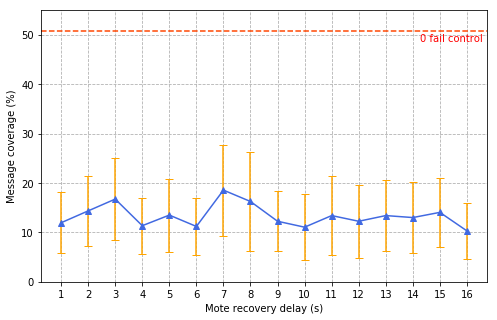

In [6]:
# graph_data('d', 'messages', experiments, control, RmhExperiment, 
#            filter_params={
#                't': 'location', 
#                'n': 6
#            },  # Begin KWargs
#            xlabel='Mote recovery delay (s)', ylabel='Total messages sent',
#            control_label='0 fail control',
#            title='Mote recovery delay vs. total messages sent',
#            figtitle='RIME Multihop in a 15x15 network, failure model=location, max concurrent failures=6', 
#            ylim=(0, 450), filename='test.png')
# graph_data('d', 'messages', experiments, control, RmhExperiment, 
#            filter_params={
#                't': 'random', 
#                'n': 11
#            },  # Begin KWargs
#            xlabel='Mote recovery delay (s)', ylabel='Total messages sent',
#            control_label='0 fail control',
#            title='Mote recovery delay vs. total messages sent',
#            figtitle='RIME Multihop in a 15x15 network, failure model=random, max concurrent failures=11', 
#            ylim=(0, 450), filename='graphs/rmh-delay-vs-msgs-random-n=11.png')
graph_data('d', 'coverage', experiments, control, RmhExperiment, 
           filter_params={
               't': 'location', 
               'n': 20
           },  # Begin KWargs
           xlabel='Mote recovery delay (s)', ylabel='Message coverage (%)',
           control_label='0 fail control', figsize=(8, 5),
           ylim=(0, 55), filename='graphs/rmh-delay-vs-coverage-location-n=1.eps')

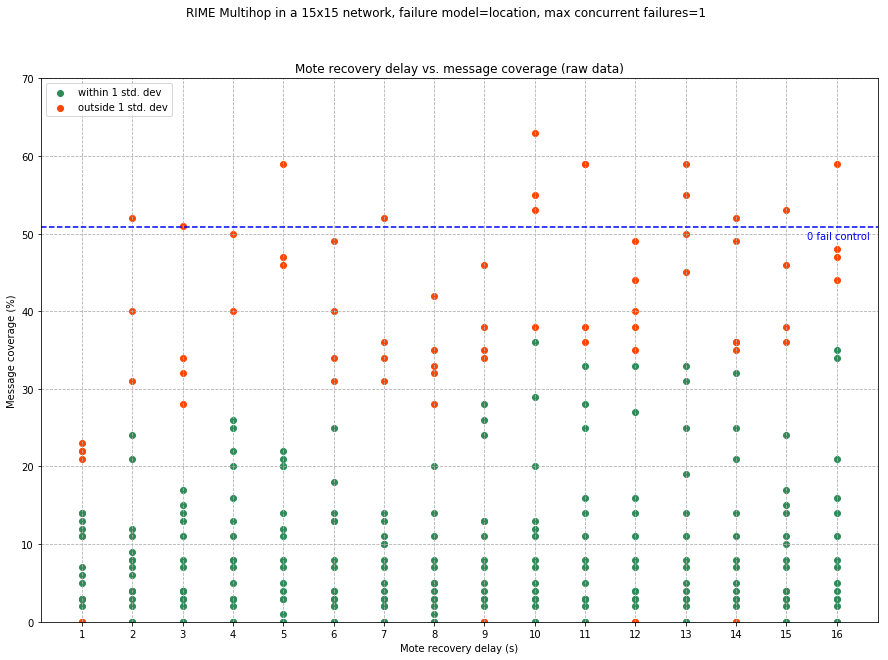

In [9]:
graph_data_scatter('d', 'coverage', experiments, control, RmhExperiment, 
           filter_params={
               't': 'location', 
               'n': 1
           },  # Begin KWargs
           xlabel='Mote recovery delay (s)', ylabel='Message coverage (%)',
           control_label='0 fail control',
           title='Mote recovery delay vs. message coverage (raw data)',
           figtitle='RIME Multihop in a 15x15 network, failure model=location, max concurrent failures=1', 
           ylim=(0, 70))#, filename='graphs/rmh-delay-vs-coverage-location-n=1-scatter.png')